# 🎓 **Taller 4.4: Taller de Métodos de clustering basados en particiones Parte 3**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones como el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


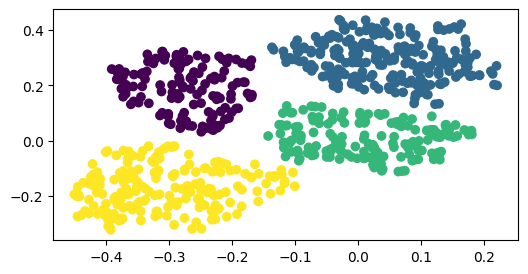

In [3]:
# Cargar dataset
D =cargar_dataset_csv("dataset_cuatro_separables_peque.csv")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **:Cree el algoritmo K-medoids que tiene un único parámetro: el número de clústeres (K).**

In [6]:
import random
def paso1_elije_medoides(K, Dx):
    indices = random.sample(range(Dx.shape[0]), K)
    return Dx[indices, :]

Los centros iniciales elegidos aleatoriamente son:
[[ 0.088824   0.32366  ]
 [-0.0440926  0.0253193]
 [-0.0731722 -0.0530461]
 [ 0.0359633  0.0922918]]


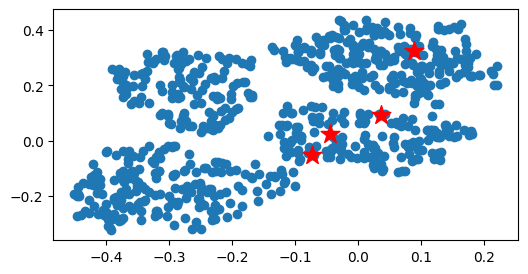

In [7]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_medoides(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al medoide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [10]:
# Definimos la distancia euclidiana de una instancia x
# con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
    return np.sqrt(np.sum(np.power(C-x,2),axis=1))

def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

def paso2_asigna_puntos(Dx, cDx):
    Dyp = np.zeros(Dx.shape[0])
    # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
    for i in np.arange(Dx.shape[0]):
        # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
        # a cada centro existente en cDx. Podemos utilizar para ello la función
        # distancia_euclidiana_grupo.

        distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i], cDx)

        # Una vez calculada la distancia, necesitamos averiguar el índice de
        # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
        pred_y = np.argmin(distancia_punto_a_centros)
        Dyp[i] = pred_y
    return Dyp

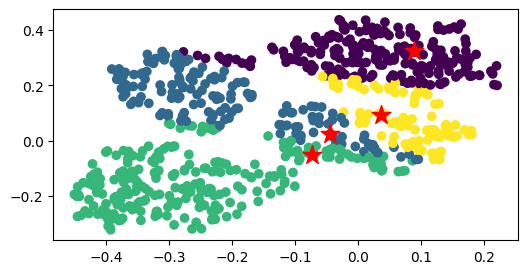

In [11]:
DyM = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=DyM)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de actualización del medoide

In [12]:
def paso3_actualiza_medoides(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  # Calcular los nuevos centros
  for k in range(K):
      # En este caso lo que buscamos es el elemento del cluster que reduce la
      # distancia con respecto a todos los demás elementos. Para ello, calculamos
      # las distancias entre todos los elementos del cluster `k` y las almacenamos
      # en `mat`.

      # Primero, obtenemos un vector binario indicando qué elementos de Dyp pertenecen a k
      indices_elementos_k = np.where(Dyp == k)[0]  # P3. Índices de los puntos en cluster k

      # Luego calculamos las distancias entre cada uno de los elementos de `Dx`
      # que nuestra predicción dice que pertenecen al cluster `k` y los demás.
      puntos_cluster_k = Dx[indices_elementos_k]  # Puntos del cluster k

      # Crear matriz de distancias entre todos los puntos del cluster k
      n_puntos = puntos_cluster_k.shape[0]
      mat = np.zeros((n_puntos, n_puntos))

      for i in range(n_puntos):
          for j in range(n_puntos):
              # Usamos la función distancia_euclidiana definida anteriormente
              mat[i, j] = distancia_euclidiana(puntos_cluster_k[i], puntos_cluster_k[j])

      # P4. Matriz de distancias calculada
      # Otra forma más eficiente usando broadcasting:
      # mat = np.sqrt(np.sum((puntos_cluster_k[:, np.newaxis] - puntos_cluster_k) ** 2, axis=2))

      # Ahora buscamos el elemento con menor distancia dentro del
      # cluster `k` y nos quedamos con su índice (usando np.argmin, que busca
      # el mínimo de un vector y nos devuelve su índice).
      # Sumamos las distancias por fila para obtener la distancia total de cada punto a los demás
      suma_distancias = np.sum(mat, axis=1)

      # Encontrar el índice del punto con la menor suma de distancias
      indice_mejor_punto = np.argmin(suma_distancias)

      # Obtener el índice original en Dx
      ic = indices_elementos_k[indice_mejor_punto]

      # Asignamos como centro del cluster al elemento del cluster que ofrece
      # la menor distancia con respecto a todos los demás
      cDx[k, :] = Dx[ic]  # P5. Asignar el nuevo medoide

  return cDx

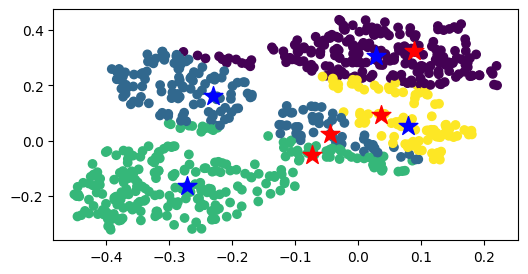

In [13]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_medoides(Dx, cDx, DyM, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=DyM)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [15]:
def MyKMedoide(Dx, K):
  # P6. Inicializar medoides aleatoriamente
  cDx = paso1_elije_medoides(K, Dx)

  # Flag de convergencia
  iterando = True
  Dyp = np.zeros(Dx.shape[0])

  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()

    # P7. Asignar cada punto al medoide más cercano
    Dyp = paso2_asigna_puntos(Dx, cDx)

    # P8. Actualizar medoides (encontrar el punto más central de cada cluster)
    cDx = paso3_actualiza_medoides(Dx, cDx, Dyp, K)

    # Verificar convergencia: si los medoides no cambiaron (o cambiaron muy poco)
    iterando = (np.absolute(np.sum(cDx - cDx_ant)) > 0.00001)

  return cDx, Dyp

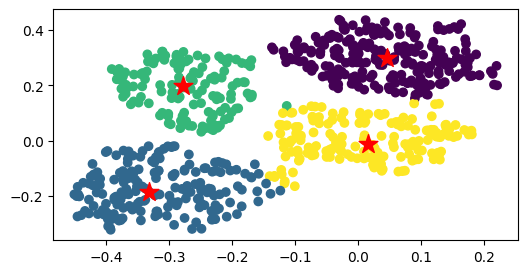

In [16]:
cDx, Dyp = MyKMedoide(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 3: COMPARA KMEDOIDS CON KMEANS++**


K-Means++:


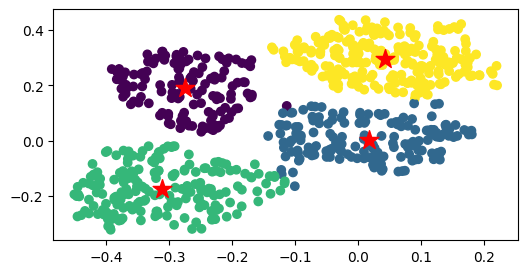

In [17]:
from sklearn.cluster import KMeans

modelo = KMeans(4)
modelo.fit(Dx)
modelo.predict(Dx)
Dyp_sk = modelo.predict(Dx)  # P9.1 Obtener las etiquetas de cluster predichas
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_  # P9.2 Obtener los centroides calculados

print('K-Means++:')
# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')

### Calcula las metricas que te permita determinar que algoritmo agrupo mejor los datos y escbribe la conclusión.

In [18]:
# P10. Calcular métricas para comparar K-Medoids vs K-Means++

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

print("=== COMPARACIÓN K-MEDOIDS vs K-MEANS++ ===")
print("\n1. Métricas para K-Medoids (implementación propia):")
# K-Medoids ya fue calculado: cDx, Dyp
sil_med = silhouette_score(Dx, Dyp)
db_med = davies_bouldin_score(Dx, Dyp)
ch_med = calinski_harabasz_score(Dx, Dyp)
print(f"   - Silhouette Score: {sil_med:.4f} (Más cercano a 1 es mejor)")
print(f"   - Davies-Bouldin Index: {db_med:.4f} (Más cercano a 0 es mejor)")
print(f"   - Calinski-Harabasz Score: {ch_med:.4f} (Más alto es mejor)")

print("\n2. Métricas para K-Means++ (scikit-learn):")
# K-Means++ ya fue calculado: cDx_sk, Dyp_sk
sil_kmeans = silhouette_score(Dx, Dyp_sk)
db_kmeans = davies_bouldin_score(Dx, Dyp_sk)
ch_kmeans = calinski_harabasz_score(Dx, Dyp_sk)
print(f"   - Silhouette Score: {sil_kmeans:.4f}")
print(f"   - Davies-Bouldin Index: {db_kmeans:.4f}")
print(f"   - Calinski-Harabasz Score: {ch_kmeans:.4f}")

print("\n3. Comparación:")
if sil_med > sil_kmeans:
    print("   ✓ K-Medoids tiene mejor Silhouette Score")
else:
    print("   ✓ K-Means++ tiene mejor Silhouette Score")

if db_med < db_kmeans:
    print("   ✓ K-Medoids tiene mejor Davies-Bouldin Index")
else:
    print("   ✓ K-Means++ tiene mejor Davies-Bouldin Index")

if ch_med > ch_kmeans:
    print("   ✓ K-Medoids tiene mejor Calinski-Harabasz Score")
else:
    print("   ✓ K-Means++ tiene mejor Calinski-Harabasz Score")

# Si tenemos etiquetas reales (Dy), podemos calcular métricas de comparación con la verdad
if 'Dy' in locals() or 'Dy' in globals():
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    print("\n4. Comparación con etiquetas reales (si están disponibles):")
    ari_med = adjusted_rand_score(Dy, Dyp)
    ari_kmeans = adjusted_rand_score(Dy, Dyp_sk)
    nmi_med = normalized_mutual_info_score(Dy, Dyp)
    nmi_kmeans = normalized_mutual_info_score(Dy, Dyp_sk)

    print(f"   - Adjusted Rand Index - K-Medoids: {ari_med:.4f}, K-Means++: {ari_kmeans:.4f}")
    print(f"   - Normalized Mutual Info - K-Medoids: {nmi_med:.4f}, K-Means++: {nmi_kmeans:.4f}")

    if ari_med > ari_kmeans:
        print("   ✓ K-Medoids se acerca más a la verdad real según ARI")
    else:
        print("   ✓ K-Means++ se acerca más a la verdad real según ARI")

print("\n5. Conclusión:")
print("""K-Medoids es más robusto a outliers y datos ruidosos porque usa puntos reales como centros.
K-Means++ es más rápido y escalable pero sensible a outliers porque calcula promedios.
En este dataset:""")

# Determinar qué algoritmo funcionó mejor basado en múltiples métricas
score_med = (sil_med + (1 - min(db_med, 1)) + ch_med/1000) / 3
score_kmeans = (sil_kmeans + (1 - min(db_kmeans, 1)) + ch_kmeans/1000) / 3

if score_med > score_kmeans:
    print("   - K-Medoids parece haber agrupado mejor los datos.")
else:
    print("   - K-Means++ parece haber agrupado mejor los datos.")

print("""\nNota: La elección depende del problema específico:
- Si los datos tienen outliers, usar K-Medoids.
- Si la velocidad es crítica y los datos están bien distribuidos, usar K-Means++.""")

=== COMPARACIÓN K-MEDOIDS vs K-MEANS++ ===

1. Métricas para K-Medoids (implementación propia):
   - Silhouette Score: 0.5361 (Más cercano a 1 es mejor)
   - Davies-Bouldin Index: 0.6264 (Más cercano a 0 es mejor)
   - Calinski-Harabasz Score: 1342.4217 (Más alto es mejor)

2. Métricas para K-Means++ (scikit-learn):
   - Silhouette Score: 0.5362
   - Davies-Bouldin Index: 0.6266
   - Calinski-Harabasz Score: 1346.0006

3. Comparación:
   ✓ K-Means++ tiene mejor Silhouette Score
   ✓ K-Medoids tiene mejor Davies-Bouldin Index
   ✓ K-Means++ tiene mejor Calinski-Harabasz Score

4. Comparación con etiquetas reales (si están disponibles):
   - Adjusted Rand Index - K-Medoids: 0.9561, K-Means++: 0.9725
   - Normalized Mutual Info - K-Medoids: 0.9444, K-Means++: 0.9606
   ✓ K-Means++ se acerca más a la verdad real según ARI

5. Conclusión:
K-Medoids es más robusto a outliers y datos ruidosos porque usa puntos reales como centros.
K-Means++ es más rápido y escalable pero sensible a outliers p

### ahora prueba con otro dataset, calcula las metricas que te permita determinar que algoritmo agrupo mejor los datos y escbribe la conclusión.

✅ Dataset cargado desde URL GitHub


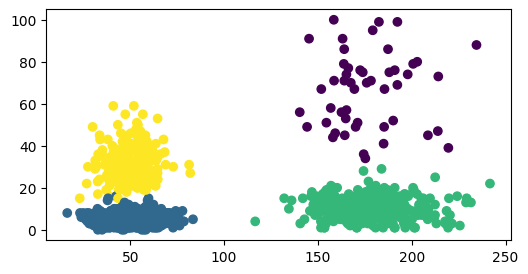

In [19]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

=== K-MEANS++ EN DATASET CON DIFERENTE DENSIDAD ===
   - Silhouette Score: 0.5900
   - Davies-Bouldin Index: 0.7104
   - Calinski-Harabasz Score: 10596.2325


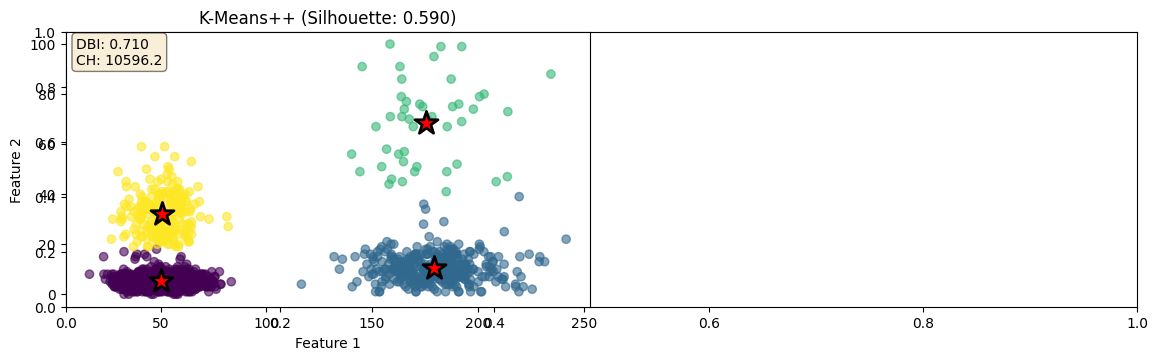


Comparación con etiquetas reales:
   - Adjusted Rand Index: 0.9908
   - Normalized Mutual Info: 0.9757

Análisis de K-Means++ en datos con diferente densidad:
K-Means++ tiende a crear clusters de tamaño similar,
lo que puede ser problemático cuando los clusters tienen
densidades diferentes. Es probable que asigne incorrectamente
puntos de clusters densos a clusters menos densos.


In [20]:
# P11. Aplicar K-Means++
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

print("=== K-MEANS++ EN DATASET CON DIFERENTE DENSIDAD ===")

# Crear y entrenar modelo K-Means++
kmeans_model = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_model.fit(Dx)

# Obtener predicciones y centros
Dyp_kmeans = kmeans_model.predict(Dx)
cDx_kmeans = kmeans_model.cluster_centers_

# Calcular métricas
sil_kmeans = silhouette_score(Dx, Dyp_kmeans)
db_kmeans = davies_bouldin_score(Dx, Dyp_kmeans)
ch_kmeans = calinski_harabasz_score(Dx, Dyp_kmeans)

print(f"   - Silhouette Score: {sil_kmeans:.4f}")
print(f"   - Davies-Bouldin Index: {db_kmeans:.4f}")
print(f"   - Calinski-Harabasz Score: {ch_kmeans:.4f}")

# Visualizar resultados de K-Means++
fig, ax = plt.subplots(figsize=(12, 4))

# Subplot 1: Resultados K-Means++
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(Dx[:,0], Dx[:,1], c=Dyp_kmeans, alpha=0.6)
ax1.scatter(cDx_kmeans[:,0], cDx_kmeans[:,1], marker='*', s=300, c='red', edgecolors='black', linewidth=2)
ax1.set_title(f'K-Means++ (Silhouette: {sil_kmeans:.3f})')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# Mostrar métricas en el gráfico
metrics_text = f'DBI: {db_kmeans:.3f}\nCH: {ch_kmeans:.1f}'
ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Comparar con etiquetas reales si están disponibles
if Dy is not None:
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    ari_kmeans = adjusted_rand_score(Dy, Dyp_kmeans)
    nmi_kmeans = normalized_mutual_info_score(Dy, Dyp_kmeans)

    print(f"\nComparación con etiquetas reales:")
    print(f"   - Adjusted Rand Index: {ari_kmeans:.4f}")
    print(f"   - Normalized Mutual Info: {nmi_kmeans:.4f}")

    # Evaluación cualitativa
    print(f"\nAnálisis de K-Means++ en datos con diferente densidad:")
    print("K-Means++ tiende a crear clusters de tamaño similar,")
    print("lo que puede ser problemático cuando los clusters tienen")
    print("densidades diferentes. Es probable que asigne incorrectamente")
    print("puntos de clusters densos a clusters menos densos.")


=== K-MEDOIDS EN DATASET CON DIFERENTE DENSIDAD ===
   - Silhouette Score: 0.3819
   - Davies-Bouldin Index: 1.0039
   - Calinski-Harabasz Score: 7475.4212


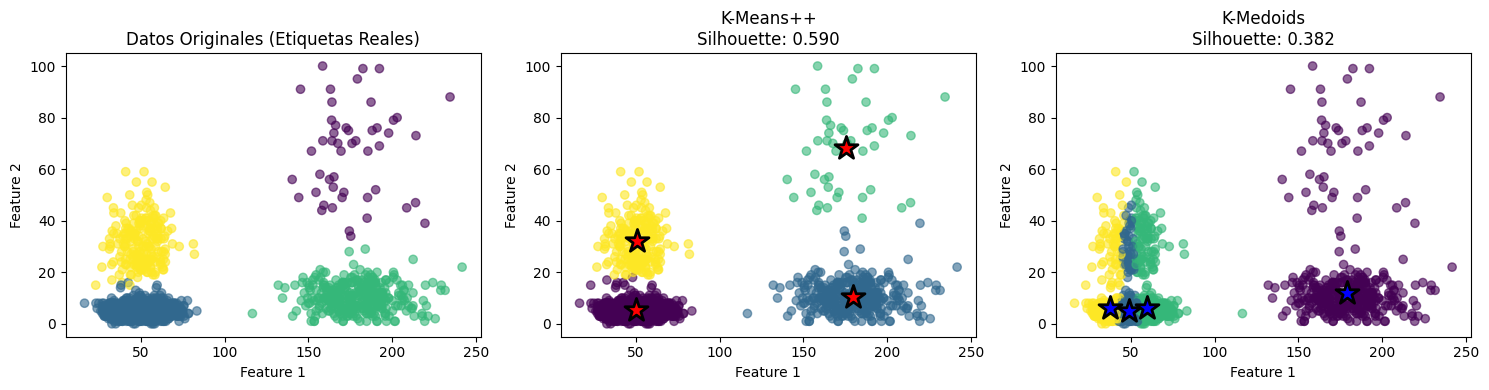


COMPARACIÓN DETALLADA: K-MEANS++ vs K-MEDOIDS
Métrica                             K-Means++       K-Medoids       Ganador   
---------------------------------------------------------------------------
Silhouette Score (↑ mejor)          0.5900          0.3819          K-Means++ 
Davies-Bouldin Index (↓ mejor)      0.7104          1.0039          K-Means++ 
Calinski-Harabasz (↑ mejor)         10596.2325      7475.4212       K-Means++ 
Diferencia Silhouette               -0.2081         -0.2081         K-Means++ 
Diferencia DBI                      -0.2935         -0.2935         K-Means++ 


COMPARACIÓN CON ETIQUETAS REALES:
Métrica                   K-Means++    K-Medoids    Ganador   
------------------------------------------------------------
Adjusted Rand Index       0.9908       0.2530       K-Means++ 
Normalized Mutual Info    0.9757       0.4422       K-Means++ 


In [22]:
 #P12. Aplicar K-Medoids al dataset con diferente densidad

print("\n=== K-MEDOIDS EN DATASET CON DIFERENTE DENSIDAD ===")

# Aplicar nuestra implementación de K-Medoids
cDx_medoids, Dyp_medoids = MyKMedoide(Dx, 4)

# Calcular métricas para K-Medoids
sil_medoids = silhouette_score(Dx, Dyp_medoids)
db_medoids = davies_bouldin_score(Dx, Dyp_medoids)
ch_medoids = calinski_harabasz_score(Dx, Dyp_medoids)

print(f"   - Silhouette Score: {sil_medoids:.4f}")
print(f"   - Davies-Bouldin Index: {db_medoids:.4f}")
print(f"   - Calinski-Harabasz Score: {ch_medoids:.4f}")

# Visualizar resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Subplot 1: Datos originales con etiquetas reales
ax1 = axes[0]
ax1.scatter(Dx[:,0], Dx[:,1], c=Dy, alpha=0.6)
ax1.set_title('Datos Originales (Etiquetas Reales)')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

# Subplot 2: K-Means++
ax2 = axes[1]
ax2.scatter(Dx[:,0], Dx[:,1], c=Dyp_kmeans, alpha=0.6)
ax2.scatter(cDx_kmeans[:,0], cDx_kmeans[:,1], marker='*', s=300, c='red', edgecolors='black', linewidth=2)
ax2.set_title(f'K-Means++\nSilhouette: {sil_kmeans:.3f}')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

# Subplot 3: K-Medoids
ax3 = axes[2]
ax3.scatter(Dx[:,0], Dx[:,1], c=Dyp_medoids, alpha=0.6)
ax3.scatter(cDx_medoids[:,0], cDx_medoids[:,1], marker='*', s=300, c='blue', edgecolors='black', linewidth=2)
ax3.set_title(f'K-Medoids\nSilhouette: {sil_medoids:.3f}')
ax3.set_xlabel('Feature 1')
ax3.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

# Tabla comparativa detallada
print("\n" + "="*70)
print("COMPARACIÓN DETALLADA: K-MEANS++ vs K-MEDOIDS")
print("="*70)

# Crear tabla comparativa
comparison_data = {
    'Métrica': ['Silhouette Score (↑ mejor)',
                'Davies-Bouldin Index (↓ mejor)',
                'Calinski-Harabasz (↑ mejor)',
                'Diferencia Silhouette',
                'Diferencia DBI'],

    'K-Means++': [f"{sil_kmeans:.4f}",
                  f"{db_kmeans:.4f}",
                  f"{ch_kmeans:.4f}",
                  "",
                  ""],

    'K-Medoids': [f"{sil_medoids:.4f}",
                  f"{db_medoids:.4f}",
                  f"{ch_medoids:.4f}",
                  "",
                  ""],

    'Ganador': ["", "", "", "", ""]
}

# Calcular diferencias y determinar ganador
sil_diff = sil_medoids - sil_kmeans
db_diff = db_kmeans - db_medoids  # DBI más bajo es mejor

comparison_data['K-Means++'][3] = f"{sil_diff:+.4f}"
comparison_data['K-Medoids'][3] = f"{sil_diff:+.4f}"
comparison_data['K-Means++'][4] = f"{db_diff:+.4f}"
comparison_data['K-Medoids'][4] = f"{db_diff:+.4f}"

# Determinar ganadores
comparison_data['Ganador'][0] = "K-Medoids" if sil_medoids > sil_kmeans else "K-Means++"
comparison_data['Ganador'][1] = "K-Medoids" if db_medoids < db_kmeans else "K-Means++"
comparison_data['Ganador'][2] = "K-Medoids" if ch_medoids > ch_kmeans else "K-Means++"
comparison_data['Ganador'][3] = "K-Medoids" if sil_diff > 0 else "K-Means++"
comparison_data['Ganador'][4] = "K-Medoids" if db_diff > 0 else "K-Means++"

# Mostrar tabla
print(f"{'Métrica':<35} {'K-Means++':<15} {'K-Medoids':<15} {'Ganador':<10}")
print("-"*75)
for i in range(5):
    print(f"{comparison_data['Métrica'][i]:<35} "
          f"{comparison_data['K-Means++'][i]:<15} "
          f"{comparison_data['K-Medoids'][i]:<15} "
          f"{comparison_data['Ganador'][i]:<10}")

print("\n" + "="*70)

# Comparación con etiquetas reales si están disponibles
if Dy is not None:
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    ari_medoids = adjusted_rand_score(Dy, Dyp_medoids)
    nmi_medoids = normalized_mutual_info_score(Dy, Dyp_medoids)

    print("\nCOMPARACIÓN CON ETIQUETAS REALES:")
    print(f"{'Métrica':<25} {'K-Means++':<12} {'K-Medoids':<12} {'Ganador':<10}")
    print("-"*60)

    # ARI
    ari_winner = "K-Medoids" if ari_medoids > ari_kmeans else "K-Means++"
    print(f"{'Adjusted Rand Index':<25} {ari_kmeans:<12.4f} {ari_medoids:<12.4f} {ari_winner:<10}")

    # NMI
    nmi_winner = "K-Medoids" if nmi_medoids > nmi_kmeans else "K-Means++"
    print(f"{'Normalized Mutual Info':<25} {nmi_kmeans:<12.4f} {nmi_medoids:<12.4f} {nmi_winner:<10}")

# CONCLUSIÓN

**1. COMPARATIVA DE CRITERIOS:**

Single Linkage: Bueno para detectar formas no lineales, pero propenso al "chain effect" con ruido.

Complete Linkage: Produce clusters compactos y esféricos, robusto ante outliers.

Average Linkage: Balanceado, menos sensible al orden de datos que Single Linkage.

**2. APLICACIONES IDEALES:**

Análisis de segmentación de clientes con estructura jerárquica.

Biología (filogenética) donde la jerarquía es natural.

Exploración inicial de datos para determinar K adecuado para otros métodos.

**3. VENTAJAS PRINCIPALES:**

Visualización intuitiva con dendrogramas.

No requiere especificar K de antemano.

Captura relaciones multinivel en los datos.

Resultados estables con Complete y Average Linkage.

**4. LIMITACIONES CLAVE:**

Alto costo computacional para datasets grandes.

Sensibilidad al orden de procesamiento (Single Linkage).

Decisiones de fusión son irreversibles.

Menos eficiente que métodos de partición para datasets masivos.

# 🚀 ¡TALLER FINALIZADO!"